# Lab: Machine learning  
*Using the cardiovascular disease dataset.*

## EDA

In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [170]:
df = pd.read_csv("../data/cardio.csv", sep=";")
df = df.drop(columns=["id"])

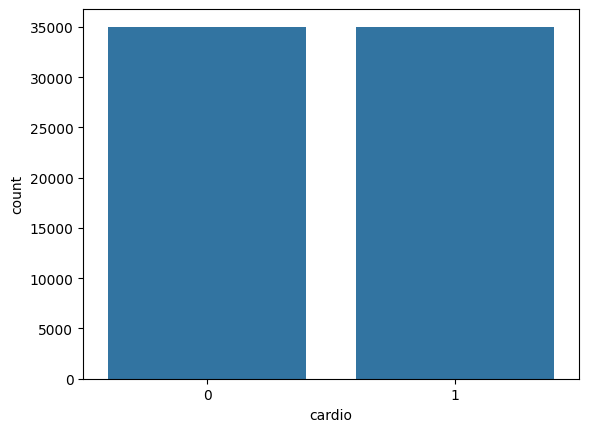

In [171]:
sns.countplot(data=df, x="cardio");

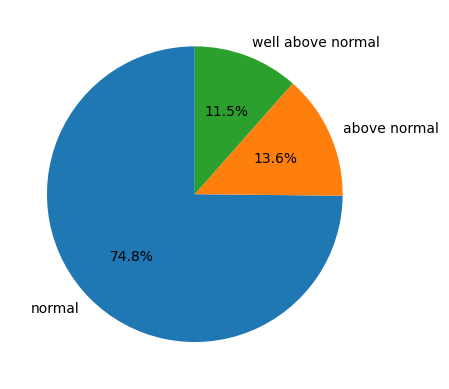

In [172]:
plt.pie(df["cholesterol"].value_counts(), labels=["normal", "above normal", "well above normal"], autopct="%1.1f%%", startangle=90);

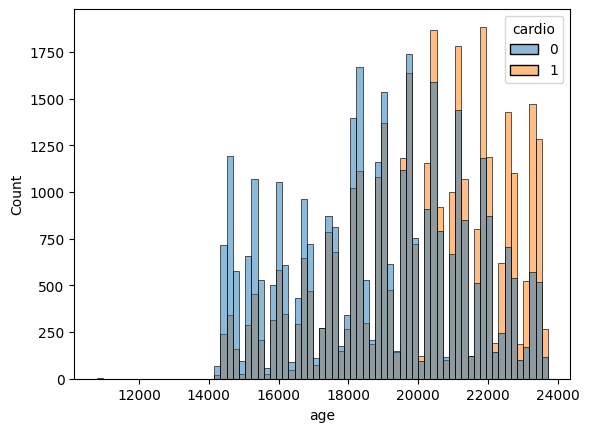

In [173]:
sns.histplot(data=df, x="age", hue="cardio");

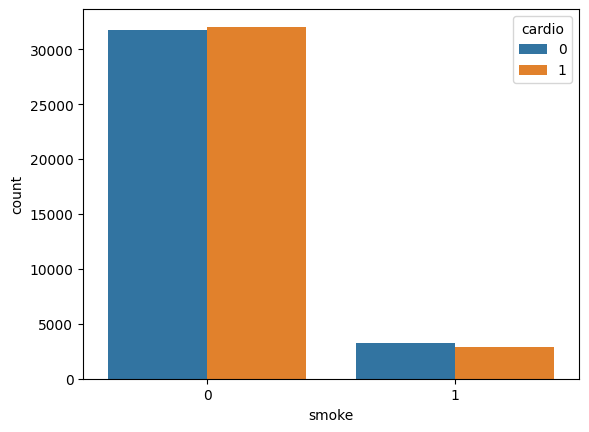

In [174]:
sns.countplot(data=df, x="smoke", hue="cardio");

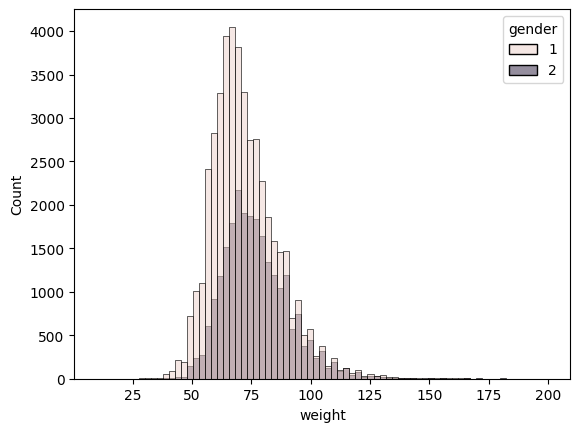

In [175]:
sns.histplot(data=df, x="weight", hue="gender", bins=75);

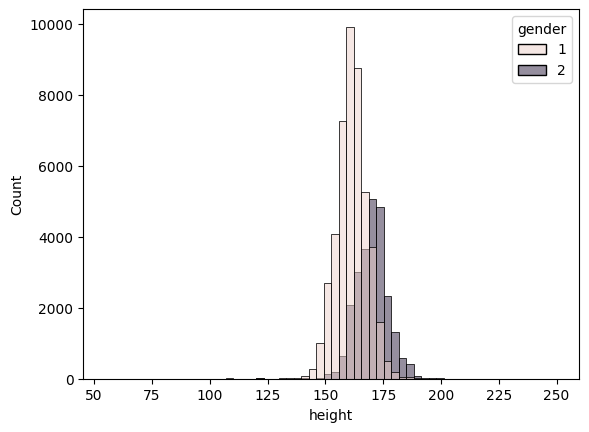

In [176]:
sns.histplot(data=df, x="height", hue="gender", bins=60);

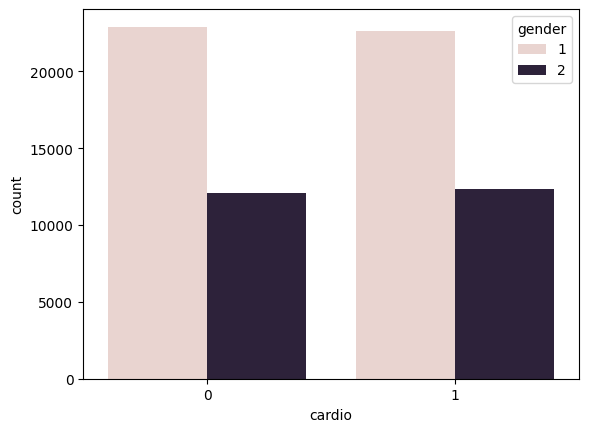

In [177]:
sns.countplot(data=df, x="cardio", hue="gender");

## Feature engineering
### BMI

In [178]:
df["bmi"] = df["weight"] / (df["height"] / 100) ** 2
df["bmi"] = df["bmi"].round(1)
df = df[["age", "gender", "height", "weight", "bmi", "ap_hi", "ap_lo", "cholesterol", "gluc", "smoke", "alco", "active", "cardio"]]
df = df[(df["bmi"] > 16) & (df["bmi"] <= 40)]

Då labbinstruktionerna hänvisar till Wikipedia används de gränsvärden angivna där. Ursprunglig källa anges vara WHO och hänvisar till att människor med värden under 16 är "svårt tunna" medan de med värden över 40 lider av "fetma klass 3". 

In [179]:
df["bmi_cat"] = pd.cut(df["bmi"], bins=[16, 18.5, 25, 30, 35, 40, float("inf")], labels=["underweight", "normal", "overweight", "obese cl1", "obese cl2", "obese cl3"])
df = df[["age", "gender", "height", "weight", "bmi", "bmi_cat", "ap_hi", "ap_lo", "cholesterol", "gluc", "smoke", "alco", "active", "cardio"]]

### blodtryck

In [180]:
df = df[(df["ap_hi"] >= 0) & (df["ap_hi"] <= 250) &
        (df["ap_lo"] >= 0) & (df["ap_lo"] <= 200)]
df.describe()

,age,gender,height,weight,bmi,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,67145.000000,67145.000000,67145.000000,67145.000000,67145.000000,67145.000000,67145.000000,67145.000000,67145.000000,67145.000000,67145.000000,67145.000000,67145.000000
mean,19455.497029,1.354382,164.562693,73.163255,27.026501,126.053764,81.203336,1.357361,1.221118,0.088852,0.053571,0.804006,0.490074
std,2470.107419,0.478329,7.802323,12.785642,4.457275,17.534776,9.779434,0.673118,0.566974,0.284533,0.225170,0.396967,0.499905
min,10798.000000,1.000000,120.000000,28.000000,16.100000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17644.000000,1.000000,159.000000,65.000000,23.800000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19695.000000,1.000000,165.000000,71.000000,26.200000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21317.000000,2.000000,170.000000,81.000000,29.800000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,207.000000,135.000000,40.000000,240.000000,190.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


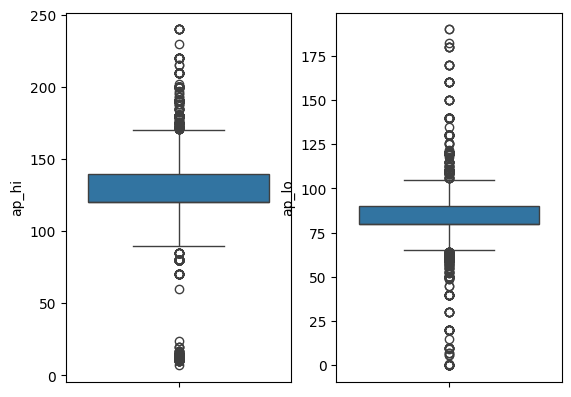

In [181]:
fig, ax = plt.subplots(1, 2)
sns.boxplot(data=df, y="ap_hi", ax=ax[0])
sns.boxplot(data=df, y="ap_lo", ax=ax[1])
plt.show()

Eftersom många outliers fortfarande är närvarande i datan används nedan IQR-metoden för att rensa fler outliers. 

In [182]:
# def clear_outliers(df):    
#     q1 = df.quantile(0.25)
#     q3 = df.quantile(0.75)
#     iqr = q3 - q1
#     lower = q1 - 1.5 * iqr
#     upper = q3 + 1.5 * iqr
#     df = df[(df >= lower) & (df <= upper)]
#     return df

# df["ap_hi"] = clear_outliers(df["ap_hi"])
# df["ap_lo"] = clear_outliers(df["ap_lo"])
# df = df.dropna(how="any")

In [183]:
# fig, ax = plt.subplots(1, 2)
# sns.boxplot(data=df, y="ap_hi", ax=ax[0])
# sns.boxplot(data=df, y="ap_lo", ax=ax[1])
# plt.show()

In [ ]:
bp_conditions = [
    (df["ap_hi"] <= 90) | (df["ap_lo"] <= 60), # with outlier I need | instead of & otherwise I get unknown values
    ((df["ap_hi"] >= 90) & (df["ap_hi"] < 120)) & (df["ap_lo"] < 80),
    ((df["ap_hi"] >= 120) & (df["ap_hi"] < 130)) & (df["ap_lo"] < 80),
    ((df["ap_hi"] >= 130) & (df["ap_hi"] < 140)) | ((df["ap_lo"] >= 80) & (df["ap_lo"] < 90)),
    ((df["ap_hi"] >= 140) & (df["ap_hi"] < 180)) | ((df["ap_lo"] >= 90) & (df["ap_lo"] < 120)),
    (df["ap_hi"] >= 180) | (df["ap_lo"] >= 120)
]
bp_labels = [
    "hypotension", 
    "normal", 
    "elevated", 
    "hypertension st1", 
    "hypertension st2", 
    "hypertension crisis"
]

df["ap_cat"] = np.select(bp_conditions, bp_labels, default="unknown")
df = df[["age", "gender", "height", "weight", "bmi", "bmi_cat", "ap_hi", "ap_lo", "ap_cat", "cholesterol", "gluc", "smoke", "alco", "active", "cardio"]]
df

,age,gender,height,weight,bmi,bmi_cat,ap_hi,ap_lo,ap_cat,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,22.0,normal,110,80,hypertension st1,1,1,0,0,1,0
1,20228,1,156,85.0,34.9,obese cl1,140,90,hypertension st2,3,1,0,0,1,1
2,18857,1,165,64.0,23.5,normal,130,70,hypertension st1,3,1,0,0,0,1
3,17623,2,169,82.0,28.7,overweight,150,100,hypertension st2,1,1,0,0,1,1
4,17474,1,156,56.0,23.0,normal,100,60,hypotension,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,21074,1,165,80.0,29.4,overweight,150,80,hypertension st1,1,1,0,0,1,1
69995,19240,2,168,76.0,26.9,overweight,120,80,hypertension st1,1,1,1,0,1,0
69997,19066,2,183,105.0,31.4,obese cl1,180,90,hypertension st2,3,1,0,1,0,1
69998,22431,1,163,72.0,27.1,overweight,135,80,hypertension st1,1,2,0,0,0,1


In [185]:
df["ap_cat"].value_counts()

ap_cat
hypertension st1       38774
hypertension st2       15248
normal                  7144
hypotension             3251
elevated                2598
hypertension crisis      130
Name: count, dtype: int64

Då labbinstruktionerna hänvisar till Healthline används de gränsvärden angivna där. Det framgår även en källhänvisning till brittiska NHS som anger gränsvärden även för lågt blodtryck vilket implementerats här likaså. 